
# SQL Injection Detection Notebook

This notebook integrates multiple approaches for SQL injection detection:
1. Fine-tuning **CodeBERT** for binary classification.
2. Utilizing **BERT embeddings** with Dense and XGBoost classifiers.
3. Employing **DNN** with pretrained embeddings.

The purposse of this project is to be able to determine which of the models performs better in classifying wether a query is harmful or not.

This is determined in the dataset by the label 0 (safe) or 1 (injection).

We will unify the dataset across all methods and evaluate their performances on a common metric set.


# Requirements

Below are listed the neccessary python libraires needed to run the project 
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu \
    transformers==4.33.0 \
    datasets==2.14.4 \
    xgboost==1.7.6 \
    scikit-learn==1.3.0 \
    tf-keras==2.13.1 \
    tensorflow==2.13.0 \
    tqdm==4.66.1 \
    numpy==1.23.5 \
    pandas==1.5.3 \
    matplotlib==3.6.2
Run this in your terminal to get started    

In [34]:
# Import Libraries
#For numerical computations and data manipulation.
import numpy as np
import pandas as pd
#Core libraries for deep learning and audio/image processing.
import torch
#For visualizing training/validation results.
import plotly.express as px
#For pre-trained models like BERT.
from transformers import RobertaTokenizer, RobertaForSequenceClassification, BertTokenizer, BertModel, TrainingArguments, Trainer
#For metrics like precision, recall, F1-score, etc.
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
#For building and training neural networks (Dense model, DNN).
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
#For the gradient boosting tree model.
from xgboost import XGBClassifier
#For progress bars
from tqdm import tqdm
#For data handling and preprocessing
from datasets import Dataset

## Models and Tokenizers
**BERT** (Bidirectional Encoder Representations from Transformers) is a transformer-based model designed to understand the context of words in a sentence by considering the words that come before and after.

**BERT Tokenizer** is a tokenizer specific to BERT, responsible for converting text into input tokens the BERT model can process.

Outputs:

	input_ids: Numeric token IDs.
	
	attention_mask: Specifies which tokens are padded.

**RoBERTa** is a robustly optimized BERT

**Roberta Tokenizer** also uses Byte-Pair Encoding (BPE) but without the next sentence prediction task-specific tokens.

**RobertaForSequenceClassification** is a pre-trained RoBERTa model tailored for sequence classification tasks 

In [ ]:
# Load CodeBERT Tokenizer and Model
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaForSequenceClassification.from_pretrained("microsoft/codebert-base", num_labels=2)  

# Initialize BERT model for embeddings
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


## Load and Explore the Dataset
The dataset is accessed at [dataset](https://www.kaggle.com/datasets/sajid576/sql-injection-dataset/data)

Download the CSV and replace the path below with your own

The dataset should include:
- `Query`: The SQL query.
- `Label`: The target class (0 = Safe, 1 = SQL Injection).


In [ ]:

# Load and Explore Dataset
# Replace the path with the path to your dataset.
df = pd.read_csv("/Users/klesi/Documents/Modified_SQL_Dataset.csv")
print(f"Dataset loaded with shape: {df.shape}")
print(df.head())
print(df.info())


## Split Dataset into Training and Testing

We'll use an 80-20 split for training and testing.
    
We convert to HuggingFace Dataset.
The Dataset supports efficient data manipulation, tokenizing text, applying transformations (e.g., truncating or padding sequences) to entire datasets efficiently.

In [ ]:
# Split Dataset into Train and Test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Training samples: {len(train_df)}, Testing samples: {len(test_df)}")

# Convert to Hugging Face Dataset Format
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Defining the evaluation metrics 
The chosen metrics according to which we will compare all our models to determine the most appropriate one.


**Accuracy**: The proportion of correctly predicted samples out of the total samples.

**Precision**: The proportion of correctly predicted positive samples out of all predicted positives.

**Recall**: The proportion of actual positive samples that were correctly predicted.

**F1**: The harmonic mean of precision and recall, balancing their trade-offs.

**Confusion Matrix**: A table showing true positives, true negatives, false positives, and false negatives for predictions.

In [ ]:
# Assuming y_true (true labels) and y_pred (predicted labels) are available
def evaluate_metrics_and_confusion(y_true, y_pred):

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Return results
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": conf_matrix
    }



## Approach 1: Fine-Tuning CodeBERT

We fine-tune CodeBERT on the dataset for binary classification.
We use the `microsoft/codebert-base` tokenizer and model.


## Tokenize the Dataset

Tokenize the SQL queries for input into CodeBERT. 

Each query is converted into `input_ids` and `attention_mask`.    

In [ ]:

# Tokenization Function that converts text into token IDs compatible with the model’s tokenizer 
def tokenize_function(examples):
    return tokenizer(
        examples["Query"],        # The text to be tokenized.
        padding = "max_length",   # Pad the text to the maximum length.
        truncation = True,        # Truncate the text to the maximum length.
        max_length = 128          # Maximum length of the text.
        )        

# Tokenize the Datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Removes the original text column ("Query") from the datasets
train_dataset = train_dataset.remove_columns(["Query"])
test_dataset = test_dataset.remove_columns(["Query"])

# Rename the label column to "labels" for compatibility with the model
train_dataset = train_dataset.rename_column("Label", "labels")
test_dataset = test_dataset.rename_column("Label", "labels")

# Cast the fields to PyTorch tensors (Multidimensinal arrays)
train_dataset.set_format("torch")
test_dataset.set_format("torch")


## Define Training Arguments

Specify hyperparameters for fine-tuning, including batch size, learning rate, and number of epochs.
    

In [ ]:
# Training configuration for fine-tuning a model using Hugging Face’s Trainer API
training_args = TrainingArguments(
    output_dir="./results",                 # Output Directory
    evaluation_strategy="epoch",            # Specifies when to evaluate the model on the validation dataset
    save_strategy="epoch",                  # Specifies when to save model checkpoints.
    learning_rate=2e-5,                     # Learning Rate for the optimizer, controlling how much to adjust the weights in each update step
    per_device_train_batch_size=32,         # Batch size per device for training
    per_device_eval_batch_size=32,          # Batch size for evaluation
    num_train_epochs=3,                     # Number of training epochs  
    weight_decay=0.01,                      # Regularization technique to prevent overfitting by reducing the magnitude of model weights
    logging_dir="./logs",                   # Logging Directory
    logging_steps=100,                      # Logs training metrics 
    save_total_limit=2,                     # Limits the number of saved checkpoints to 2 
    load_best_model_at_end=True,            # Loads the best model at the end of training
    metric_for_best_model="accuracy"        # Metric used to determine the “best” model during training
)
    


**Define Metrics for Evaluation**

Accuracy, precision, recall, and F1 score are used to evaluate the model. These metrics are for the training process of this model.
    

In [ ]:
def compute_metrics(pred):
    logits, labels = pred                                               # Dictionary containing The raw predictions and the true labels for the data.
    predictions = np.argmax(logits, axis=1)                             # Converts the raw logits into class predictions 
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        predictions,
        average="binary")
    acc = accuracy_score(labels, predictions)                            # Indicates that this is a binary classification task
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}  


## Fine-Tune CodeBERT

Use the Hugging Face Trainer to fine-tune CodeBERT on the training dataset.
    

In [ ]:

# Define Trainer
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
    tokenizer = tokenizer,
    compute_metrics = compute_metrics
)

# Train the Model
trainer.train()
    

**Example of results**

![exaple](image.png)


## Evaluate the Model

Evaluate the fine-tuned model on the test dataset.

In [57]:


# Get predictions and labels
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
y_true = predictions.label_ids

# Convert logits to binary predictions
y_pred_roberta = np.argmax(logits, axis=1)  # For classification

# Evaluate RoBERTa
roberta_results = evaluate_metrics_and_confusion(y_true, y_pred_roberta)

print("RoBERTa Fine-Tuning Evaluation:")
print("Accuracy       :", roberta_results["accuracy"])
print("Precision      :", roberta_results["precision"])
print("Recall         :", roberta_results["recall"])
print("F1-Score       :", roberta_results["f1"])
print("Confusion Matrix:\n", roberta_results["confusion_matrix"])

RoBERTa Fine-Tuning Evaluation:
Accuracy       : 0.9987063389391979
Precision      : 1.0
Recall         : 0.9965080750763858
F1-Score       : 0.9982509838216004
Confusion Matrix:
 [[3893    0]
 [   8 2283]]



## Approach 2: BERT Embeddings with Dense Network and XGBoost

We use BERT embeddings as feature vectors for classifying queries using Dense and XGBoost classifiers.


# Define a function that transforms the queries to embbedings (vector representations) using pretrained model 

**Parameters:**
	
    queries: A list of text strings (queries) to process.
	
    batch_size: Number of queries processed at a time.

In [ ]:
# Function to extract BERT embeddings 
def get_bert_embeddings(queries, batch_size=32):
    embeddings = []
    # tqdm: Displays a progress bar to show the status of the process.
    for i in tqdm(range(                                # Iterates over the queries in batches of size batch_size
        0,                                              # Starting index of the queries
        len(queries),                                   # Ending index of the queries
        batch_size),                                    # Step size
        desc = "Extracting BERT embeddings"):           # Label to show the process status.
        batch_queries = queries[i:i+batch_size]         # Selects a batch of queries
        # Tokenize the queries
        tokens = bert_tokenizer(
            batch_queries,                              # List of queries to tokenize
            return_tensors = 'pt',                      # Returns the tokenized data as PyTorch tensors
            padding = True,                             # Pads shorter queries t
            truncation = True,                          # Truncates longer queries
            max_length = 128)                           # Maximum length of the queries
        with torch.no_grad():                           # Disables gradient computation 
            outputs = bert_model(**tokens)              # Contains the embeddings for each token in the sequence
        # Averages the token embeddings across each sequence  to produce a single embedding vector for each query.
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).numpy()  
        embeddings.append(batch_embeddings)             # Appends the embeddings for each token in the sequence.
    return np.vstack(embeddings)                        # Combine all batches into one array

# Extract BERT embeddings for the training and testing datasets
train_embeddings = get_bert_embeddings(list(train_df['Query']))
test_embeddings = get_bert_embeddings(list(test_df['Query']))


Extracting BERT embeddings: 100%|██████████| 194/194 [02:04<00:00,  1.56it/s]


# Initialize a Dense Neural Network

The logic behind this model lies in creating a linear stack of layers of mathematical units, where each layer feeds its output to the next.

Optimal for feed-forward neural networks

Every neuron in a layer communicates with every neuron in the other layer, adjusting the weights therefore called dense.

In [43]:
# Creates a linear stack of layers
dense_model = Sequential([
    Dense(128, activation = 'relu'),    # Adds a fully connected (dense) layer with 128 neurons and Rectified Linear Unit (ReLU) activation function.
    Dropout(0.2),                       # Randomly sets 20% of the input units to avoid overfitting. 
    Dense(1, activation = 'sigmoid')    # Adds a dense layer with a single neuron and sigmoid activation function to keep the values between 1 and 0.
])

# Compiles the model
dense_model.compile(
    optimizer = 'adam',               # Optimizer that adjusts the learning rate during training based on the data
    loss = 'binary_crossentropy',     # Loss function used to measure the model's performance
        metrics=[                     # Metrics used to evaluate the model
        'accuracy',
        'precision',
        'recall'
    ])           

In [ ]:
# Train the model
history = dense_model.fit(
    train_embeddings,           # Input data for training(in this case, the BERT embeddings)
    train_df['Label'],          # Target data for training
    epochs=5,                   # Specifies the number of complete passes through the training dataset.
    batch_size=32,              # Number of samples processed before the model is updated.  
    validation_data=(test_embeddings, test_df['Label'])  #Tracks the model’s performance on unseen data to monitor overfitting
)

**EXAMPLE OUTPUT**
Epoch 1/5
773/773 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9788 - loss: 0.0705 - precision: 0.9820 - recall: 0.9607 - val_accuracy: 0.9966 - val_loss: 0.0115 - val_precision: 0.9943 - val_recall: 0.9965
Epoch 2/5
773/773 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9961 - loss: 0.0130 - precision: 0.9961 - recall: 0.9933 - val_accuracy: 0.9979 - val_loss: 0.0085 - val_precision: 0.9983 - val_recall: 0.9961
Epoch 3/5
773/773 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9975 - loss: 0.0089 - precision: 0.9970 - recall: 0.9961 - val_accuracy: 0.9968 - val_loss: 0.0090 - val_precision: 0.9952 - val_recall: 0.9961
Epoch 4/5
773/773 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9986 - loss: 0.0054 - precision: 0.9990 - recall: 0.9970 - val_accuracy: 0.9977 - val_loss: 0.0099 - val_precision: 0.9982 - val_recall: 0.9956
Epoch 5/5
773/773 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9985 - loss: 0.0052 - precision: 0.9984 - recall: 0.9976 - val_accuracy: 0.9976 - val_loss: 0.0109 - val_precision: 0.9987 - val_recall: 0.9948


## Evaluate the Model

Evaluate the DNN model according to the defined metrics.

In [59]:
y_true = test_df['Label']
y_pred = (dense_model.predict(test_embeddings) > 0.5).astype("int32")

# Evaluate
results = evaluate_metrics_and_confusion(y_true, y_pred)
# Access metrics
print("DNN Evaluation:")
print("Accuracy       :", results["accuracy"])
print("Precision      :", results["precision"])
print("Recall         :", results["recall"])
print("F1-Score       :", results["f1"])
print("Confusion Matrix:\n", results["confusion_matrix"])


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
CNN Evaluation:
Accuracy       : 0.9975743855109961
Precision      : 0.9986853637160386
Recall         : 0.9947621126145788
F1-Score       : 0.9967198775420949
Confusion Matrix:
 [[3890    3]
 [  12 2279]]


#   Initialize the XGBoost Classifier
XGBoost classifier, is an implementation of the gradient boosting algorithm for classification tasks that uses decision trees as base learners.

In [55]:
# Fit the model to the training data consisting of BERT embeddings and the corresponding labels
xgb = XGBClassifier()
xgb.fit(train_embeddings, train_df['Label'])

# Uses the trained model to predict labels for the test data giving an array of labels as output
predictions = xgb.predict(test_embeddings)
print(predictions)


[1 0 0 ... 1 0 0]


In [58]:
# XGBoost Model Evaluation
y_pred_xgb = xgb.predict(test_embeddings)
xgb_results = evaluate_metrics_and_confusion(y_true, y_pred_xgb)

print("\nXGBoost Model Evaluation:")
print("Accuracy       :", xgb_results["accuracy"])
print("Precision      :", xgb_results["precision"])
print("Recall         :", xgb_results["recall"])
print("F1-Score       :", xgb_results["f1"])
print("Confusion Matrix:\n", xgb_results["confusion_matrix"])


XGBoost Model Evaluation:
Accuracy       : 0.9967658473479948
Precision      : 0.997807978956598
Recall         : 0.9934526407682235
F1-Score       : 0.9956255468066492
Confusion Matrix:
 [[3888    5]
 [  15 2276]]



## Results Comparison

Here, we compare the performances of all approaches using standard metrics like accuracy, precision, recall, and F1-score.


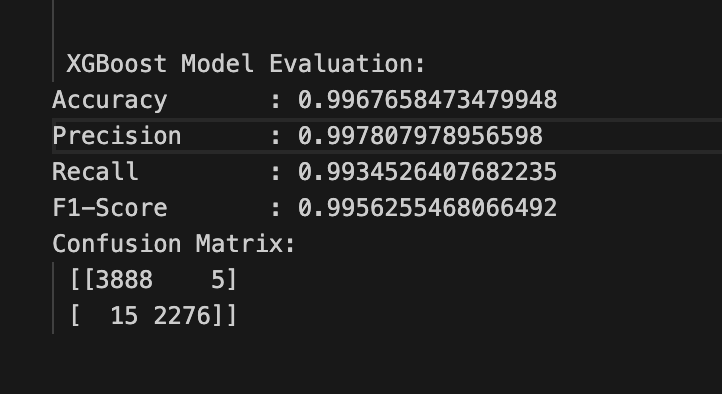
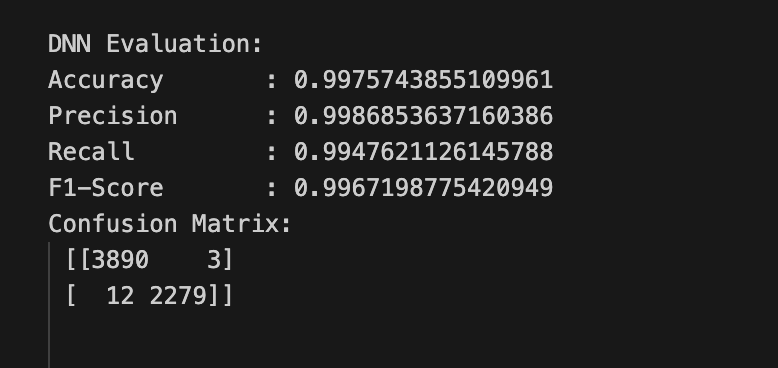
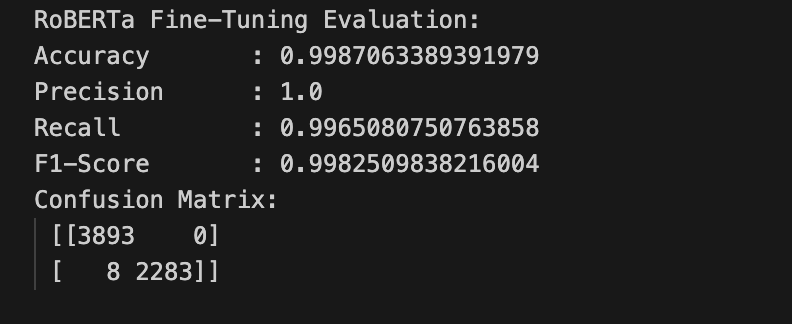


**Accuracy**:
RoBERTa: 99.87%

DNN: 99.76%

XGBoost: 99.68%

All models are highly accurate, with RoBERTa slightly outperforming the others. This suggests all models are well-trained and able to predict correctly for the majority of samples.

**Precision**

RoBERTa: 1.0 (100% precision)

DNN: 99.87%
    
XGBoost: 99.78%

RoBERTa achieves perfect precision, meaning every positive prediction is correct (no false positives). This is ideal in scenarios where false positives are costly.

**Recall**

RoBERTa: 99.65%

DNN: 99.48%

XGBoost: 99.34%

RoBERTa performs slightly better than DNN and XGBoost in recall. This means it misses fewer positive samples (fewer false negatives).

**F1-Score**
    
RoBERTa: 99.83%

DNN: 99.67%

XGBoost: 99.56%

RoBERTa’s higher F1-Score confirms it balances precision and recall better than the other models.

**Confusion Matrix Analysis**

RoBERTa:

Achieves a perfect true negative rate (no false positives).Slightly better in capturing true positives with only 8 false negatives.
	
DNN and XGBoost:
    
Have slightly higher false positives and false negatives compared to RoBERTa.CNN slightly outperforms XGBoost in all confusion matrix elements.